# Evaluation on Set5 and Set14

Evaluate two metrics PSNR and SSIM of trained models on 5 and 14 validation images at scale of 2 and 4.


In [1]:
from tensorflow import config

gpu_devices = config.experimental.list_physical_devices('GPU')

for device in gpu_devices: config.experimental.set_memory_growth(device, True)

## Load testing images from directory

In [3]:
# load testing images from directory

import os
import numpy as np
from PIL import Image

# Load Set5 images
#LR_valid_path = './datasets/Set5_X4/'
LR_valid_path = './datasets/Set5_X2/'
HR_valid_path = './datasets/Set5/'

# Load Set14 images
#LR_valid_path = './datasets/Set14_X4/'
#LR_valid_path = './datasets/Set14_X2/'
#HR_valid_path = './datasets/Set14/'


LR_train_imgs = []
HR_train_imgs = []

for path, subpath, files in os.walk(LR_train_path):
    files.sort()
    for i in files:
        if i == '.DS_Store':
            continue
        img = Image.open(LR_train_path + i)
        LR_train_imgs.append(np.asarray(img))

for path, subpath, files in os.walk(HR_train_path):
    files.sort()
    for i in files:
        if i == '.DS_Store':
            continue
        img = Image.open(HR_train_path + i)
        HR_train_imgs.append(np.asarray(img)) 

print(len(LR_train_imgs))
print(len(HR_train_imgs))

13
13


## Load trained model for evaluation

In [4]:
import tensorflow as tf
from keras.models import load_model

model = load_model('./model_and_history/final_mse_4848_12000_subpixel_X2.h5', custom_objects={'tf': tf})

#model.summary()

Using TensorFlow backend.


In [5]:
# normaliza imgs from 0~255 to 0~1

def normalize(imgs):
    return imgs / 255

def denormalize(imgs):
    imgs = imgs * 255
    return imgs.astype(np.uint8)

for i in range(len(LR_valid_imgs)):
    LR_valid_imgs[i] = normalize(LR_valid_imgs[i])

## Use trained model to predict test images
Smaller stride can result in better performance but cost more time to recover as more patches are involved. Time needed to predict 100 validation images are recorded with corresponding stride.

In [6]:
# stride should be smaller than patch size, or there may be vancancy

from extract_patches import *

test_num = 5
patch_height = 48
patch_width = 48
stride = 5
up_scale = 2

import time

time_start=time.time()

predicted_HR_list = test_patch(LR_valid_imgs, test_num, patch_height, patch_width, stride, model, up_scale)

time_end=time.time()
print('Time cost to predict: ', time_end-time_start, 's')

for i in range(len(predicted_HR_list)):
    predicted_HR_list[i] = denormalize(predicted_HR_list[i])

    
# Set5_X2
# stride=5, test_num=5, Time cost to predict:  27.667843341827393 s

# Set5_X4
# stride=5, test_num=5, Time cost to predict:  11.060781717300415 s

# Set14_X2
# stride=5, test_num=14, Time cost to predict:  142.93742322921753 s

# Set14_X4
# stride=5, test_num=14, Time cost to predict:  47.753403663635254 s



Time cost to predict:  142.93742322921753 s


In [15]:
# compare with HR images 
# calculate PSNR(peak_signal_noise_ratio) and SSIM(structural_similarity) metrics

from skimage.metrics import peak_signal_noise_ratio, structural_similarity

PSNR_val = []
SSIM_val = []

for i in range(len(predicted_HR_list)):
    PSNR = peak_signal_noise_ratio(HR_valid_imgs[i], predicted_HR_list[i])
    SSIM = structural_similarity(HR_valid_imgs[i], predicted_HR_list[i], multichannel=True)
    PSNR_val.append(PSNR)
    SSIM_val.append(SSIM)

print('PSNR: ', PSNR_val)
print('SSIM: ', SSIM_val)

PSNR:  [23.259891622676655, 26.81100107027052, 28.529539473537294, 26.287757708609863, 31.49612979439917, 29.986642988768537, 32.4277646930696, 32.200109926769386, 29.10615261807982, 34.82672526225169, 30.315489680007932, 28.860341936127725, 30.948270878966383]
SSIM:  [0.7225702105778984, 0.860906299219793, 0.8504712325698471, 0.9088156171901652, 0.8329348362339929, 0.9042548232881131, 0.9562496447445809, 0.8673111630985577, 0.8804808791874251, 0.965210597847396, 0.8370286257363687, 0.9462497187549781, 0.9378557719492968]


In [16]:
# save evaluation results

import pickle

with open('./evaluation/set14_x2_psnr.pkl','wb') as f2:
    pickle.dump(PSNR_val, f2)

with open('./evaluation/set14_x2_ssim.pkl','wb') as f3:
    pickle.dump(SSIM_val, f3)

## Calculate the PSNR and SSIM of interpolation methods (bicubic, nearest neighbor)

In [ ]:
# load testing images from directory

import os
import numpy as np
from PIL import Image

# Load Set5 images
#LR_valid_path = './datasets/Set5_X4/'
LR_valid_path = './datasets/Set5_X2/'
HR_valid_path = './datasets/Set5/'

# Load Set14 images
#LR_valid_path = './datasets/Set14_X4/'
#LR_valid_path = './datasets/Set14_X2/'
#HR_valid_path = './datasets/Set14/'

LR_train_imgs = []
HR_train_imgs = []

for path, subpath, files in os.walk(LR_train_path):
    files.sort()
    for i in files:
        if i == '.DS_Store':
            continue
        img = Image.open(LR_train_path + i)
        LR_train_imgs.append(np.asarray(img))

for path, subpath, files in os.walk(HR_train_path):
    files.sort()
    for i in files:
        if i == '.DS_Store':
            continue
        img = Image.open(HR_train_path + i)
        HR_train_imgs.append(np.asarray(img)) 

print(len(LR_train_imgs))
print(len(HR_train_imgs))

In [ ]:
# cv2.INTER_NEAREST, cv2.INTER_LINEAR, cv2.INTER_CUBIC, cv2.INTER_AREA
from PIL import Image
import cv2
import numpy as np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

psnr_res = []
ssim_res = []


for i in range(5):
    img = set5_x2[i]
    hr_img = set5[i]
    resized = cv2.resize(img, (img.shape[1]*2, img.shape[0]*2), interpolation = cv2.INTER_NEAREST)
    
    if hr_img.shape != resized.shape:
        temp = np.zeros(hr_img.shape)
        temp = resized[:temp.shape[0], :temp.shape[1], :]
        
        psnr_res.append(peak_signal_noise_ratio(hr_img, temp))
        ssim_res.append(structural_similarity(hr_img, temp, multichannel=True))
        continue
    
    psnr_res.append(peak_signal_noise_ratio(hr_img, resized))
    ssim_res.append(structural_similarity(hr_img, resized, multichannel=True))


print(psnr_res)
print(ssim_res)

In [9]:
import numpy as np

print('psnr_mean:', np.mean(psnr_res))
print('ssim_mean:', np.mean(ssim_res))

psnr_mean: 32.618908688442346
ssim_mean: 0.9309457502125025


## Extract patches of recovered image

In [1]:
from PIL import Image
import numpy as np

hr_img = np.asarray(Image.open('./dataset/DIV2K_valid_HR/0861.png'))

bi_img = np.asarray(Image.open('./evaluation/images/unknown_bicubic_61.png'))
mse_img = np.asarray(Image.open('./evaluation/images/unknown_mse_61.png'))
vgg_img = np.asarray(Image.open('./evaluation/images/unknown_vgg_61.png'))

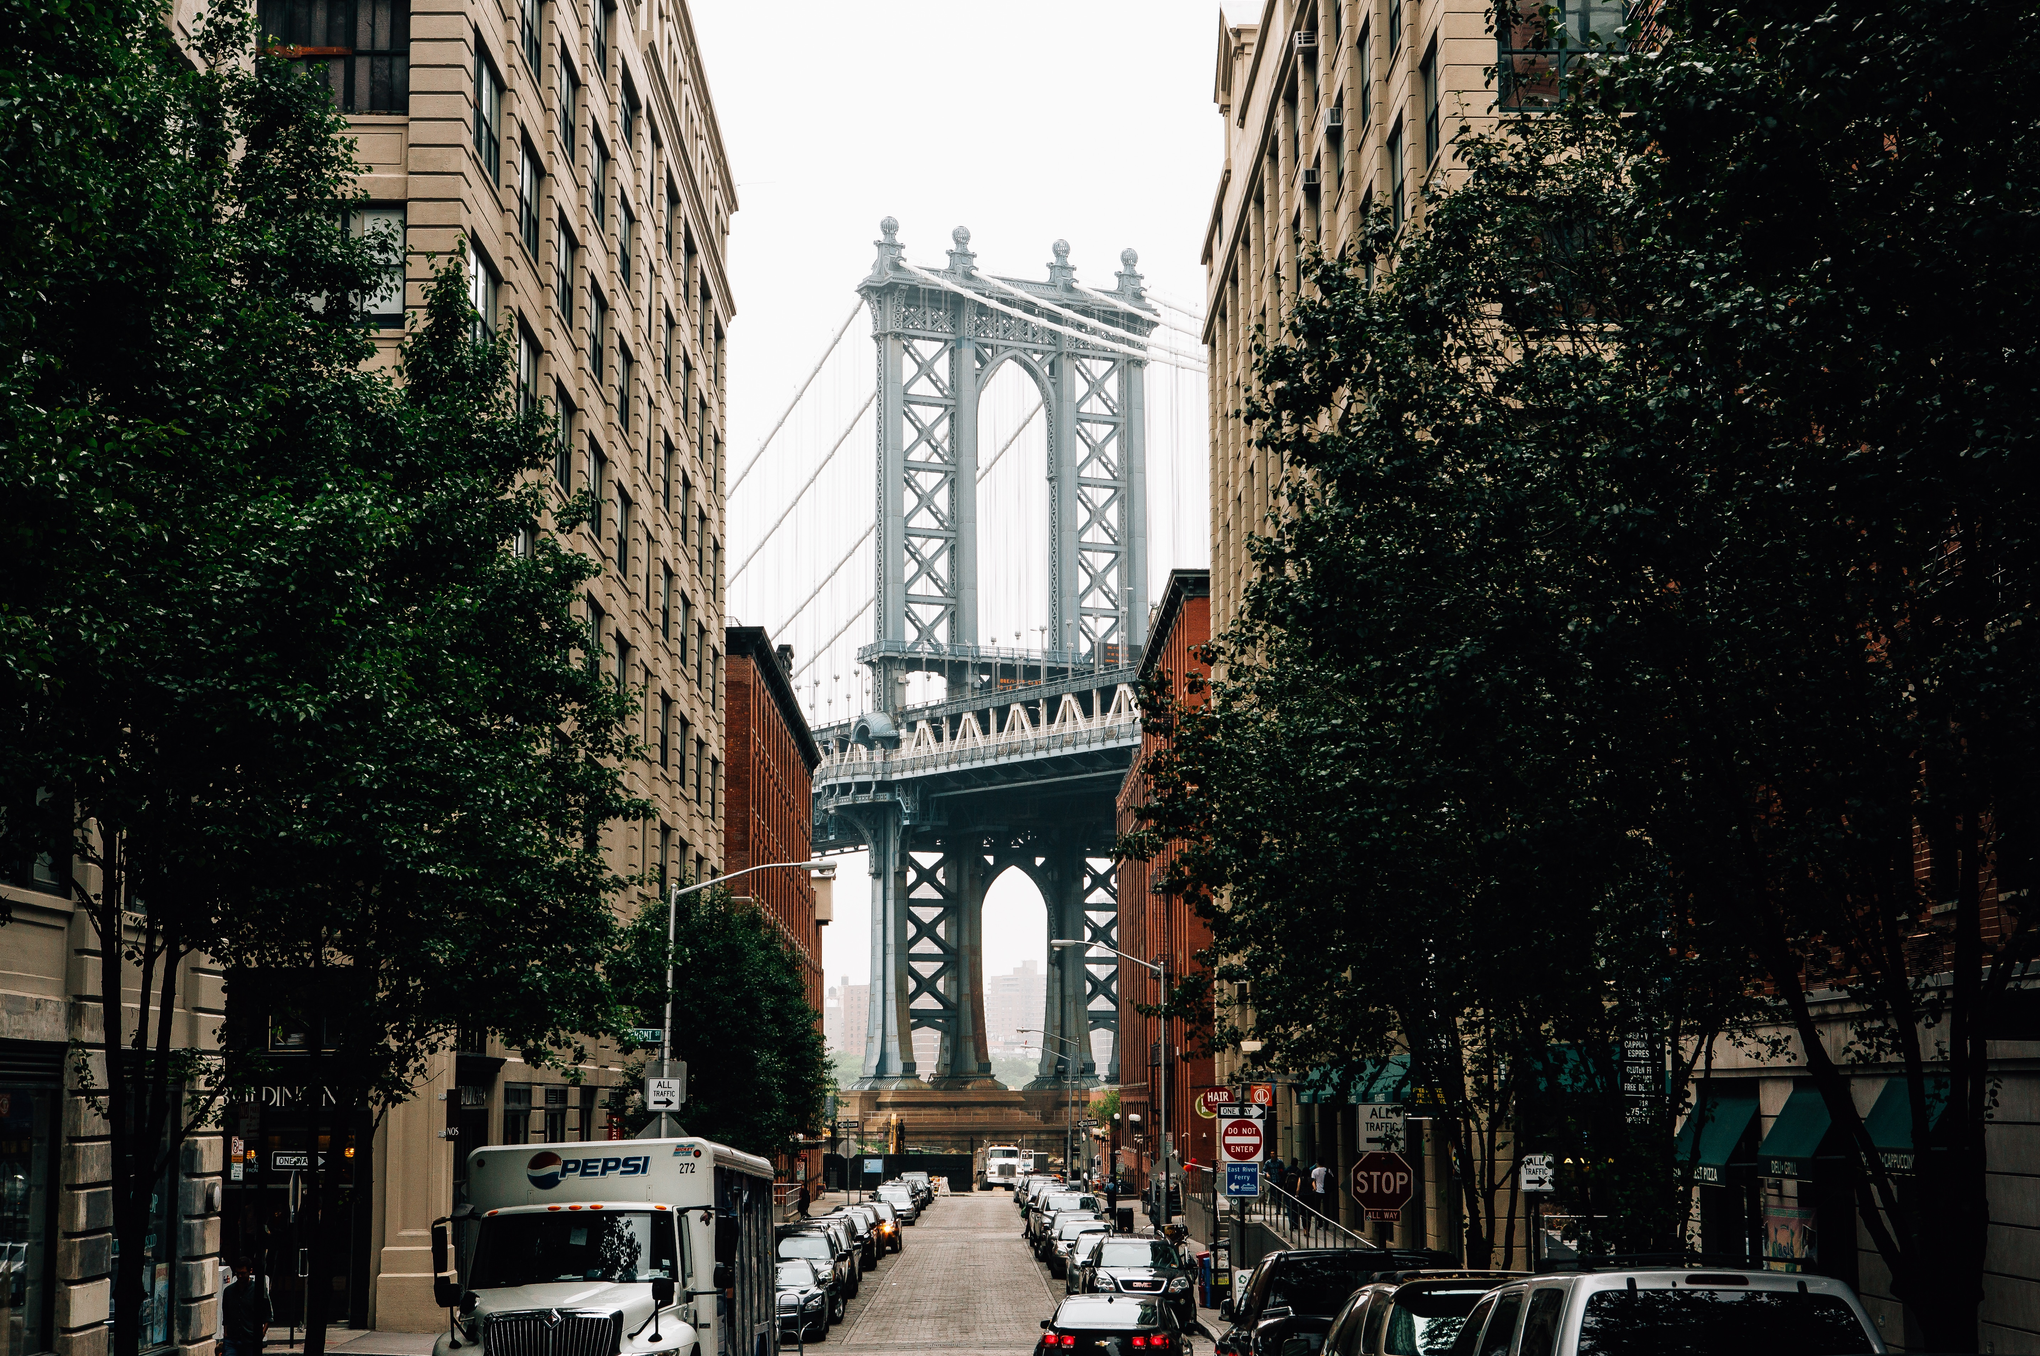

In [2]:
Image.fromarray(hr_img, 'RGB')

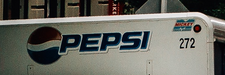

In [3]:
h_l = 1125
h_r = 1200
w_l = 500
w_r = 725
Image.fromarray(hr_img[h_l:h_r, w_l:w_r, :])

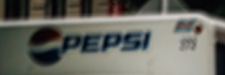

In [4]:
Image.fromarray(bi_img[h_l:h_r, w_l:w_r, :])

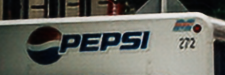

In [5]:
Image.fromarray(mse_img[h_l:h_r, w_l:w_r, :])

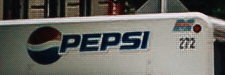

In [6]:
Image.fromarray(vgg_img[h_l:h_r, w_l:w_r, :])

In [7]:
# PSNR(peak_signal_noise_ratio) and SSIM(structural_similarity) 都是越大越好

from skimage.metrics import peak_signal_noise_ratio, structural_similarity


PSNR = []
SSIM = []

PSNR.append(peak_signal_noise_ratio(np.asarray(Image.fromarray(hr_img[h_l:h_r, w_l:w_r, :]))
                                    , np.asarray(Image.fromarray(bi_img[h_l:h_r, w_l:w_r, :]))))
PSNR.append(peak_signal_noise_ratio(np.asarray(Image.fromarray(hr_img[h_l:h_r, w_l:w_r, :]))
                                    , np.asarray(Image.fromarray(mse_img[h_l:h_r, w_l:w_r, :]))))
PSNR.append(peak_signal_noise_ratio(np.asarray(Image.fromarray(hr_img[h_l:h_r, w_l:w_r, :]))
                                    , np.asarray(Image.fromarray(vgg_img[h_l:h_r, w_l:w_r, :]))))
            
SSIM.append(structural_similarity(np.asarray(Image.fromarray(hr_img[h_l:h_r, w_l:w_r, :]))
                                  , np.asarray(Image.fromarray(bi_img[h_l:h_r, w_l:w_r, :])), multichannel=True))
SSIM.append(structural_similarity(np.asarray(Image.fromarray(hr_img[h_l:h_r, w_l:w_r, :]))
                                  , np.asarray(Image.fromarray(mse_img[h_l:h_r, w_l:w_r, :])), multichannel=True))
SSIM.append(structural_similarity(np.asarray(Image.fromarray(hr_img[h_l:h_r, w_l:w_r, :]))
                                  , np.asarray(Image.fromarray(vgg_img[h_l:h_r, w_l:w_r, :])), multichannel=True))

print('PSNR: ', PSNR)
print('SSIM: ', SSIM)

PSNR:  [18.885628679627747, 27.496677103385792, 24.696858316196824]
SSIM:  [0.5940459498393992, 0.8945286756447907, 0.7259601180503591]
